In [1]:
import numpy as np 
from utils import read_dataset, drop_useless
import os 

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [2]:
# read data from backend 
# fill motion capturing data if gap is <= 1 sec if gaps are greater drop gaps and split data into sets 
# apply moving average filter on mocap to smooth, rectify and apply moving average on emg
SUBJECT = "Finn"

dataset = read_dataset(SUBJECT,
                       # timestamp="10-12-24",
                       read_ort=False)
for nd in dataset:
    nd.fill(1.0)
dataset = drop_useless(dataset)
for nd in dataset: 
    nd.moving_average_filter(30, on="emg")
    nd.moving_average_filter(10, on="joints")

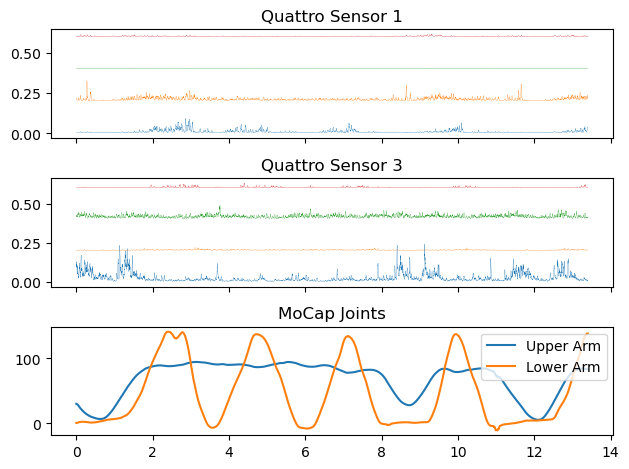

In [3]:
# Sample plot of one set
dataset[0].plot(plot_emg=True, plot_mocap_joints=True)

In [4]:
from numpy.lib.stride_tricks import sliding_window_view

def prepare_data_narx(n: int, data, lstm_ready: bool=True): 
    """ Prepares the data: Adds <n> previous joints to output """
    joints = data[0][:, -1, :]
    past = sliding_window_view(joints, (n, 2))
    if lstm_ready: 
        past = past.reshape(-1, n, 2)
    else: 
        past = past.reshape(-1, n*2)
    return data[-1][n:], joints[n:], past[:-1]

In [5]:
# prepare data: windowed emg data [..., 222, 8]: 222 Samples per win ~ 0.1sec = 100msec, 8 channels
# corresponding target: joint data [..., 2]: 2 joints Flexion/Extension and Pronation/Supination
# past joints: n - past joints (for narx) [..., 8]: 4 (n past samples) * 2 joints = 8, respectivly (4 <n_prev>, 2 <joints>) for lstm
# targets is 50 ms ahead of everything else

n_win = 10
n_prev = 4
emg_data, joints, past_joints = zip(*[prepare_data_narx(n_prev, d.get_data(n_win, n_win, 222, n_win/2)) for d in dataset])

In [6]:
# norm emg: cumbersome, but needed to keep the chronical order
emg_max, emg_min = max(ed.max() for ed in emg_data), min(ed.min() for ed in emg_data)
emg_data = [(ed - emg_min) / (emg_max - emg_min) for ed in emg_data]
emg_max, emg_min

(np.float32(1.3130887), np.float32(2.4274932e-05))

In [7]:
# norm joints 
joints_max, joints_min = max(x.max() for x in past_joints), min(x.min() for x in past_joints)
joints = [(jd - joints_min) / (joints_max - joints_min) for jd in joints]
past_joints = [(pj - joints_min) / (joints_max - joints_min) for pj in past_joints]
joints_max, joints_min

(np.float32(157.01103), np.float32(-28.994228))

In [8]:
# Define first model part (emg model)  

from tensorflow import keras
from keras.models import Sequential, Model, clone_model
from keras.layers import Dropout, Dense, LSTM, Input, concatenate
from keras.optimizers import Adam

emg_features = Sequential()
emg_features.add(Input((222, 8)))
emg_features.add(LSTM(32, return_sequences=True))
emg_features.add(Dropout(0.2))
emg_features.add(LSTM(16))
emg_features.add(Dense(16, activation="relu"))
emg_features.add(Dense(8, activation="relu"))

E0000 00:00:1737023180.242729    3122 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737023180.244842    3122 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1737023181.324206    3122 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9726 MB memory:  -> device: 0, name: NVIDIA RTX A2000 12GB, pci bus id: 0000:01:00.0, compute capability: 8.6


In [9]:
emg_features.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 222, 32)        │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 222, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,792 (34.34 KB)

 Trainable params: 8,792 (34.34 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
input1 = Input(shape=(222,8))
output1 = emg_features(input1)

In [11]:
# define second part of the model which addes past joints -> This allows to make predictions based on the
# last position of the arm : For example if arm is at (25°, 25°) next position is more likely to be at (30°, 20°) than (120°, 0°) 
# to furthermore allow the model to get motion information (velocity, acceleration etc.) 4 previous positions are included

past_features = Sequential()
past_features.add(Input((4, 2)))
past_features.add(LSTM(4))
past_features.add(Dropout(0.2))
past_features.add(Dense(8))
past_features.add(Dense(4))

past_features.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 4)              │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 188 (752.00 B)

 Trainable params: 188 (752.00 B)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Merge both models together and decode merge features to two predicted joints (flex/ext and pron/supi)

input2 = Input(shape=(4, 2))
output2 = past_features(input2)

merged = concatenate([output1, output2])
layer = Dense(8, activation="relu")(merged)
final_output = Dense(2, activation="relu")(layer)

In [13]:
model = Model(inputs=[input1, input2], outputs=final_output)
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 222, 8)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 4, 2)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 8)         │      8,792 │ input_layer_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 4)         │        188 │ input_layer_3[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 12)        │          0 │ sequential[0][0], │
│ (Concatenate)       │                   │            │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 8)         │        104 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 2)         │         18 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,102 (35.55 KB)

 Trainable params: 9,102 (35.55 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# shuffle data -> this is needed to ensure data from different sessions is included in train, val and test data 
# shuffle inside train, val and test data will be preformed later
indices = np.arange(len(emg_data))
np.random.seed(100)
np.random.shuffle(indices)
for set_ in (emg_data, joints, past_joints): 
    set_[:] = [set_[idx] for idx in indices] 

emg_data[0].shape

(490, 222, 8)

In [15]:
# split data -> each sequential set will stay untouched and will be added to train, val or test data
# As can be seen in output, splitted data does not reach exactly desired size
def split(*sets):
    total = sum(len(s) for s in sets[0])
    cur_set = 0
    train_data, val_data, test_data = [], [], []
    amounts = [0, 0, 0]
    for data in zip(*sets): 
        if cur_set < 0.75 * total: 
            train_data.append(data)
            amounts[0] = cur_set / total
        elif 0.75 * total <= cur_set < 0.875 * total: 
            val_data.append(data)
            amounts[1] = cur_set / total
        else: 
            test_data.append(data)
            amounts[2] = cur_set / total
        cur_set += len(data[0])
    print(amounts)
    return train_data, val_data, test_data


train_data, val_data, test_data = split(emg_data, past_joints, joints)

[0.7479940688183367, 0.874927823431863, 0.9870059080851614]


In [16]:
# Train teacher forcing model 
# inputs will stay the same during the whole training process - this is different to scheduled sampling where model is forced to 
# make predictions based on previous predidictions - meaning the input will not stay the same (see next cell) 

def prepare_data(data): 
    """ Prepares the data for teacher forcing, e.g. make array form and shuffle """
    data = [np.vstack(x) for x in zip(*data)]
    indices = np.arange(data[0].shape[0])
    np.random.seed(100)
    np.random.shuffle(indices)
    for d in data: 
        d[:] = d[indices]
    return data
    
    
def train_teacher_forcing(m, t_data, v_data): 
    """ Teacher forcing training """
    emg_train, past_joints_train, joints_train = prepare_data(t_data)
    emg_val, past_joints_val, joints_val = prepare_data(v_data)
    m.compile(optimizer=Adam(learning_rate=5e-4), loss="mse")
    history = m.fit((emg_train, past_joints_train), joints_train, 
                    validation_data=((emg_val, past_joints_val), joints_val), 
                    batch_size=32, 
                    epochs=50)
    return history


teacher_force_model = clone_model(model)
teacher_forcing_hist = train_teacher_forcing(teacher_force_model, train_data, test_data)

Epoch 1/50


I0000 00:00:1737023185.048780    3232 cuda_dnn.cc:529] Loaded cuDNN version 90300


5083/5083 ━━━━━━━━━━━━━━━━━━━━ 106s 20ms/step - loss: 0.0297 - val_loss: 0.0016
Epoch 2/50
5083/5083 ━━━━━━━━━━━━━━━━━━━━ 100s 20ms/step - loss: 0.0045 - val_loss: 0.0011
Epoch 3/50
5083/5083 ━━━━━━━━━━━━━━━━━━━━ 101s 20ms/step - loss: 0.0037 - val_loss: 0.0012
Epoch 4/50
5083/5083 ━━━━━━━━━━━━━━━━━━━━ 102s 20ms/step - loss: 0.0034 - val_loss: 9.5910e-04
Epoch 5/50
5083/5083 ━━━━━━━━━━━━━━━━━━━━ 103s 20ms/step - loss: 0.0032 - val_loss: 8.9741e-04
Epoch 6/50
5083/5083 ━━━━━━━━━━━━━━━━━━━━ 96s 19ms/step - loss: 0.0032 - val_loss: 9.4815e-04
Epoch 7/50
5083/5083 ━━━━━━━━━━━━━━━━━━━━ 104s 20ms/step - loss: 0.0031 - val_loss: 9.2298e-04
Epoch 8/50
5083/5083 ━━━━━━━━━━━━━━━━━━━━ 105s 21ms/step - loss: 0.0031 - val_loss: 9.1038e-04
Epoch 9/50
5083/5083 ━━━━━━━━━━━━━━━━━━━━ 102s 20ms/step - loss: 0.0031 - val_loss: 0.0010
Epoch 10/50
5083/5083 ━━━━━━━━━━━━━━━━━━━━ 101s 20ms/step - loss: 0.0030 - val_loss: 8.9127e-04
Epoch 11/50
5083/5083 ━━━━━━━━━━━━━━━━━━━━ 104s 20ms/step - loss: 0.0030 - va

In [61]:
# Different to teacher forcing, schedulded sampleing forces the model to train on its own predictions 
# this is more realistic in real application as there is no "teacher" presenting former predictions 
# to train the model we are starting of with teacher forcing, e.g. presenting actual measured positions 
# and by time more and more model predictions will be inputted into the model 

import tensorflow as tf 
import time 
import json 
import pickle 
from typing import Literal
from collections import namedtuple

Info = namedtuple("Info", "lengths shuf_idx unshuf_idx")


class ScheduledSamplingTrainer: 

    def __init__(self, m, t_data, v_data, learning_rate: float = 5e-4, clipvalue=None, batch_size:int =32): 
        self.optimizer = Adam(learning_rate=learning_rate, clipvalue=clipvalue)
        self.train_metric = keras.metrics.MeanSquaredError()
        self.val_metric = keras.metrics.MeanSquaredError()
        self.model = m
        self._batch_size = batch_size
        self._val_data = self._prepare_data(v_data, self._get_shuffle_info(v_data))
        self._train_shuf_info = self._get_shuffle_info(t_data)
        self._train_data = self._prepare_data(t_data, self._train_shuf_info)
        
    def _prepare_data(self, data, info: Info): 
        """ Shuffles data and prepares batches for training """
        data = [np.vstack(x) for x in zip(*data)]
        res = []
        for set_ in data: 
            set_[:] = set_[info.shuf_idx]
            split = data[0].shape[0] % self._batch_size 
            full, remainder = np.split(set_, (-split, ))
            res.append(list(set_[:-split].reshape(-1, 32, *set_.shape[1:])) + [remainder])            
        return list(zip(*res))

    @staticmethod
    def _unshuffle_data(data, info: Info):
        """ Reverses the _prepare_data method. Needed for scheduled sampling """
        res = []
        for d in zip(*data): 
            d = np.vstack(d)
            d = d[info.unshuf_idx]
            res.append(np.split(d, info.lengths))
        return list(zip(*res))
        
    @staticmethod
    def _get_shuffle_info(data):
        """ Returns information on how to shuffle and reverse shuffle """
        data, *_ = zip(*data)
        lengths = [x.shape[0] for x in data]
        indices = np.arange(sum(lengths))
        np.random.seed(5)
        np.random.shuffle(indices)
        unshuf_indices = np.zeros_like(indices)
        unshuf_indices[indices] = np.arange(sum(lengths))
        return Info(np.cumsum(lengths[:-1]), indices, unshuf_indices)
        
    @tf.function
    def train_step(self, x, y): 
        with tf.GradientTape() as tape:
            logits = self.model(x, training=True)
            loss_value = keras.losses.MeanSquaredError()(y, logits)
        grads = tape.gradient(loss_value, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        self.train_metric.update_state(y, logits)
        return logits
    
    @tf.function
    def val_step(self, x, y): 
        logits = self.model(x, training=False)
        self.val_metric.update_state(y, logits)

    def _generate_new(self, samples): 
        """ This method unshuffles (train) data, makes new past_joints_train list (first <n_prev> values are kept) based on random sampling and shuffles back """
        updated_past_joints = []
        for sampled_data, past_joints_prev in self._unshuffle_data(samples, self._train_shuf_info): 
            past = sliding_window_view(sampled_data, (n_prev, 2))
            past = past.reshape(-1, n_prev, 2)
            updated_past_joints.append([np.vstack((past_joints_prev[:4], past[:-1]))])
        return [x[0] for x in self._prepare_data(updated_past_joints, self._train_shuf_info)]

    @staticmethod
    def _linear_decay(epochs, warm_up=0): 
        for i in range(warm_up): 
            yield 1
        for epoch in range(epochs - warm_up): 
            yield 1 - epoch / (epochs - 1) 
            
    def train_loop(self, epochs, warm_up=0):
        """ Trains the model: as epsilon counts down more and more model predictions will be inputted """
        history = []
        decay_fn = self._linear_decay(epochs, warm_up)
        _, past_joints_train, _ = zip(*self._train_data)
        for epoch, epsilon in enumerate(decay_fn, start=1): 
            start_time = time.time()
            samples = []
            for i, (emg_batch, _, y_batch) in enumerate(self._train_data): 
                pred = self.train_step((emg_batch, past_joints_train[i]), y_batch)
                pred = np.where(pred < 0, 0, pred)
                pred = np.where(pred > 1, 1, pred)
                sampler = np.where(np.random.random(pred.shape) < epsilon, y_batch, pred)
                samples.append((sampler, past_joints_train[i]))
            
            past_joints_train = self._generate_new(samples)
                
            for emg_val, past_joints_val, y_val in self._val_data: 
                self.val_step((emg_val, past_joints_val), y_val)
            history.append((self.train_metric.result().numpy(), self.val_metric.result().numpy()))
            print(
                (f"Epoch {(epoch):4} / {epochs} \t taking {round(time.time() - start_time):5} sec"
                f"\t loss: {self.train_metric.result():.4f} \t val_loss {self.val_metric.result():.4f}"))
            self.train_metric.reset_state()
            self.val_metric.reset_state()
        return history
        

In [44]:
path = os.path.join("models", SUBJECT, "narx")
TestVal = namedtuple("TestVal", "learning_rate epochs")
tests = (TestVal(5e-4, 50), TestVal(1e-4, 50), TestVal(5e-5, 100), TestVal(1e-5, 100), TestVal(1e-5, 500))
hists = []
for test in tests: 
    print(test.learning_rate, test.epochs)
    sds_model = clone_model(model)
    sst = ScheduledSamplingTrainer(sds_model, train_data, val_data, learning_rate=test.learning_rate)
    hists.append(sst.train_loop(test.epochs))
    sds_model.save(os.path.join(path, f"model_{test.epochs}_{int(test.learning_rate*100_000)}.keras"))

0.0005 50
Epoch    1 / 50 	 taking    98 sec	 loss: 0.0104 	 val_loss 0.0018
Epoch    2 / 50 	 taking    92 sec	 loss: 0.0043 	 val_loss 0.0011
Epoch    3 / 50 	 taking    94 sec	 loss: 0.0041 	 val_loss 0.0011
Epoch    4 / 50 	 taking    95 sec	 loss: 0.0040 	 val_loss 0.0011
Epoch    5 / 50 	 taking    93 sec	 loss: 0.0041 	 val_loss 0.0014
Epoch    6 / 50 	 taking    93 sec	 loss: 0.0041 	 val_loss 0.0013
Epoch    7 / 50 	 taking    99 sec	 loss: 0.0041 	 val_loss 0.0011
Epoch    8 / 50 	 taking    96 sec	 loss: 0.0042 	 val_loss 0.0013
Epoch    9 / 50 	 taking    94 sec	 loss: 0.0043 	 val_loss 0.0012
Epoch   10 / 50 	 taking    93 sec	 loss: 0.0044 	 val_loss 0.0016
Epoch   11 / 50 	 taking    95 sec	 loss: 0.0045 	 val_loss 0.0012
Epoch   12 / 50 	 taking    92 sec	 loss: 0.0046 	 val_loss 0.0013
Epoch   13 / 50 	 taking    94 sec	 loss: 0.0046 	 val_loss 0.0014
Epoch   14 / 50 	 taking    94 sec	 loss: 0.0047 	 val_loss 0.0014
Epoch   15 / 50 	 taking    96 sec	 loss: 0.0048 	 v

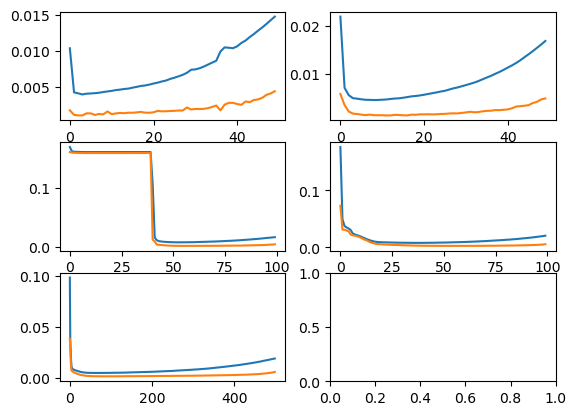

In [66]:
import matplotlib.pyplot as plt 

fig, axs = plt.subplots(3, 2)
axs[0, 0].plot(np.array(hists[0]))
axs[0, 1].plot(np.array(hists[1]))
axs[1, 0].plot(np.array(hists[2]))
axs[1, 1].plot(np.array(hists[3]))
axs[2, 0].plot(np.array(hists[4]))

In [63]:
sds_model = clone_model(model)
sst = ScheduledSamplingTrainer(sds_model, train_data, val_data, learning_rate=5e-5, clipvalue=0.5)
hits = sst.train_loop(100, 20)

Epoch    1 / 100 	 taking   101 sec	 loss: 0.0293 	 val_loss 0.0081
Epoch    2 / 100 	 taking    98 sec	 loss: 0.0089 	 val_loss 0.0049
Epoch    3 / 100 	 taking    94 sec	 loss: 0.0068 	 val_loss 0.0036
Epoch    4 / 100 	 taking    96 sec	 loss: 0.0057 	 val_loss 0.0025
Epoch    5 / 100 	 taking    98 sec	 loss: 0.0051 	 val_loss 0.0021
Epoch    6 / 100 	 taking    95 sec	 loss: 0.0049 	 val_loss 0.0020
Epoch    7 / 100 	 taking    94 sec	 loss: 0.0048 	 val_loss 0.0019
Epoch    8 / 100 	 taking    97 sec	 loss: 0.0047 	 val_loss 0.0018
Epoch    9 / 100 	 taking    99 sec	 loss: 0.0046 	 val_loss 0.0017
Epoch   10 / 100 	 taking    97 sec	 loss: 0.0046 	 val_loss 0.0017
Epoch   11 / 100 	 taking    94 sec	 loss: 0.0045 	 val_loss 0.0016
Epoch   12 / 100 	 taking   100 sec	 loss: 0.0044 	 val_loss 0.0015
Epoch   13 / 100 	 taking    99 sec	 loss: 0.0043 	 val_loss 0.0014
Epoch   14 / 100 	 taking    94 sec	 loss: 0.0043 	 val_loss 0.0014
Epoch   15 / 100 	 taking    97 sec	 loss: 0.004

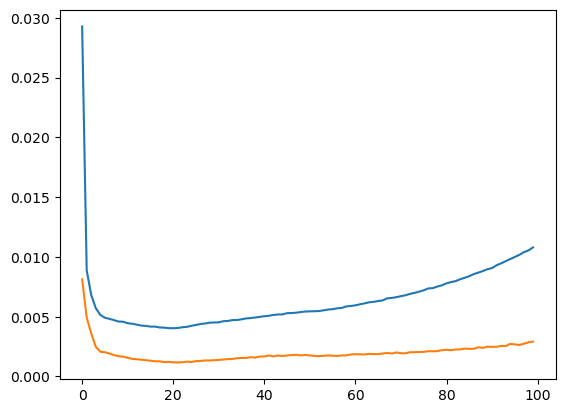

In [68]:
sds_model.save(os.path.join(path, "model001.keras"))
plt.plot(np.array(hits))

Epoch    1 / 1000 	 taking    98 sec	 loss: 0.0806 	 val_loss 0.0308
Epoch    2 / 1000 	 taking   105 sec	 loss: 0.0248 	 val_loss 0.0173
Epoch    3 / 1000 	 taking   100 sec	 loss: 0.0170 	 val_loss 0.0111
Epoch    4 / 1000 	 taking    99 sec	 loss: 0.0137 	 val_loss 0.0093
Epoch    5 / 1000 	 taking    96 sec	 loss: 0.0121 	 val_loss 0.0085
Epoch    6 / 1000 	 taking   104 sec	 loss: 0.0112 	 val_loss 0.0078
Epoch    7 / 1000 	 taking    99 sec	 loss: 0.0104 	 val_loss 0.0071
Epoch    8 / 1000 	 taking    94 sec	 loss: 0.0096 	 val_loss 0.0064
Epoch    9 / 1000 	 taking    93 sec	 loss: 0.0089 	 val_loss 0.0058
Epoch   10 / 1000 	 taking    96 sec	 loss: 0.0084 	 val_loss 0.0054
Epoch   11 / 1000 	 taking   100 sec	 loss: 0.0082 	 val_loss 0.0052
Epoch   12 / 1000 	 taking    99 sec	 loss: 0.0079 	 val_loss 0.0049
Epoch   13 / 1000 	 taking    94 sec	 loss: 0.0077 	 val_loss 0.0048
Epoch   14 / 1000 	 taking    96 sec	 loss: 0.0075 	 val_loss 0.0046
Epoch   15 / 1000 	 taking    98 s

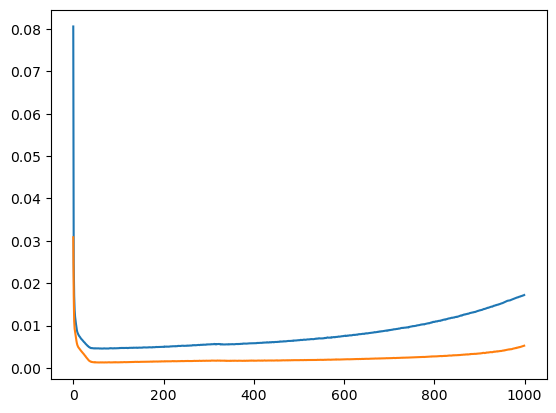

In [71]:
sds_model = clone_model(model)
sst = ScheduledSamplingTrainer(sds_model, train_data, val_data, learning_rate=1e-5, clipvalue=0.35)
hist = sst.train_loop(1000, 20)
sds_model.save(os.path.join(path, "model002.keras"))
plt.plot(np.array(hist))